# Insurance Classification and Regression

The Sure Tomorrow insurance company wants to solve several tasks with the help of Machine Learning and you are asked to evaluate that possibility.

- Task 1: Find customers who are similar to a given customer. This will help the company's agents with marketing.
- Task 2: Predict whether a new customer is likely to receive an insurance benefit. Can a prediction model do better than a dummy model?
- Task 3: Predict the number of insurance benefits a new customer is likely to receive using a linear regression model.
- Task 4: Protect clients' personal data without breaking the model from the previous task. It's necessary to develop a data transformation algorithm that would make it hard to recover personal information if the data fell into the wrong hands. This is called data masking, or data obfuscation. But the data should be protected in such a way that the quality of machine learning models doesn't suffer. You don't need to pick the best model, just prove that the algorithm works correctly.

# Data Preprocessing & Exploration

## Initialization

In [1]:
!pip install -q --user --upgrade pandas matplotlib seaborn sklearn scikit-learn scipy

In [2]:
import warnings
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.linear_model
import sklearn.metrics
import sklearn.neighbors
import sklearn.preprocessing

from sklearn.model_selection import train_test_split, cross_validate
from sklearn.neighbors import NearestNeighbors as sk_KNN
from sklearn.neighbors import KNeighborsClassifier as sk_KNNC
from sklearn.metrics import get_scorer
from sklearn.utils import shuffle

# from scipy.spatial import distance

from IPython.display import display, Markdown
from pprint import pprint

In [3]:
random_state = 42

## Load Data

Load data and conduct a basic check that it's free from obvious issues.

In [4]:
def parse_dataset(filename):
    try:
        return pd.read_csv(filename)
    except:
        return pd.read_csv(f'/datasets/$filename')


In [5]:
df = parse_dataset('insurance_us.csv')

We rename the colums to make the code look more consistent with its style.

In [6]:
df = df.rename(columns={'Gender': 'gender', 'Age': 'age', 'Salary': 'income', 'Family members': 'family_members', 'Insurance benefits': 'insurance_benefits'})

In [7]:
df.sample(10)

,gender,age,income,family_members,insurance_benefits
1991,0,18.0,30400.0,1,0
4692,1,28.0,38400.0,3,0
3748,1,26.0,42200.0,1,0
2330,0,40.0,42000.0,0,0
2420,1,28.0,41800.0,2,0
1913,1,29.0,45200.0,0,0
4898,1,28.0,39800.0,0,0
3686,0,27.0,32600.0,1,0
2702,0,25.0,35700.0,0,0
3211,0,31.0,40100.0,0,0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   float64
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


In [9]:
# we may want to fix the age type (from float to int) though this is not critical

# write your conversion here if you choose:

df['age'] = pd.to_numeric(df['age'], downcast='integer')
df['gender'] = pd.to_numeric(df['gender'], downcast='integer')
df['family_members'] = pd.to_numeric(df['family_members'], downcast='integer')
df['insurance_benefits'] = pd.to_numeric(df['insurance_benefits'], downcast='integer')

In [10]:
# check to see that the conversion was successful
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int8   
 1   age                 5000 non-null   int8   
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int8   
 4   insurance_benefits  5000 non-null   int8   
dtypes: float64(1), int8(4)
memory usage: 58.7 KB


In [11]:
# now have a look at the data's descriptive statistics. 
# Does everything look okay?

In [12]:
df.describe()

,gender,age,income,family_members,insurance_benefits
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.499000,30.952800,39916.360000,1.194200,0.148000
std,0.500049,8.440807,9900.083569,1.091387,0.463183
min,0.000000,18.000000,5300.000000,0.000000,0.000000
25%,0.000000,24.000000,33300.000000,0.000000,0.000000
50%,0.000000,30.000000,40200.000000,1.000000,0.000000
75%,1.000000,37.000000,46600.000000,2.000000,0.000000
max,1.000000,65.000000,79000.000000,6.000000,5.000000


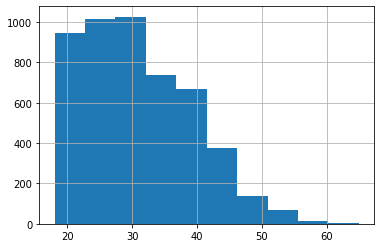

In [13]:
df['age'].hist();

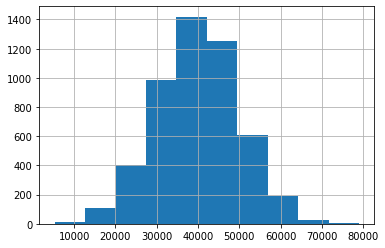

In [14]:
df['income'].hist();

There are no obvious anomalies, nor missing values.  
Data seem to be in order.

## EDA

Let's quickly check whether there are certain groups of customers by looking at the pair plot.

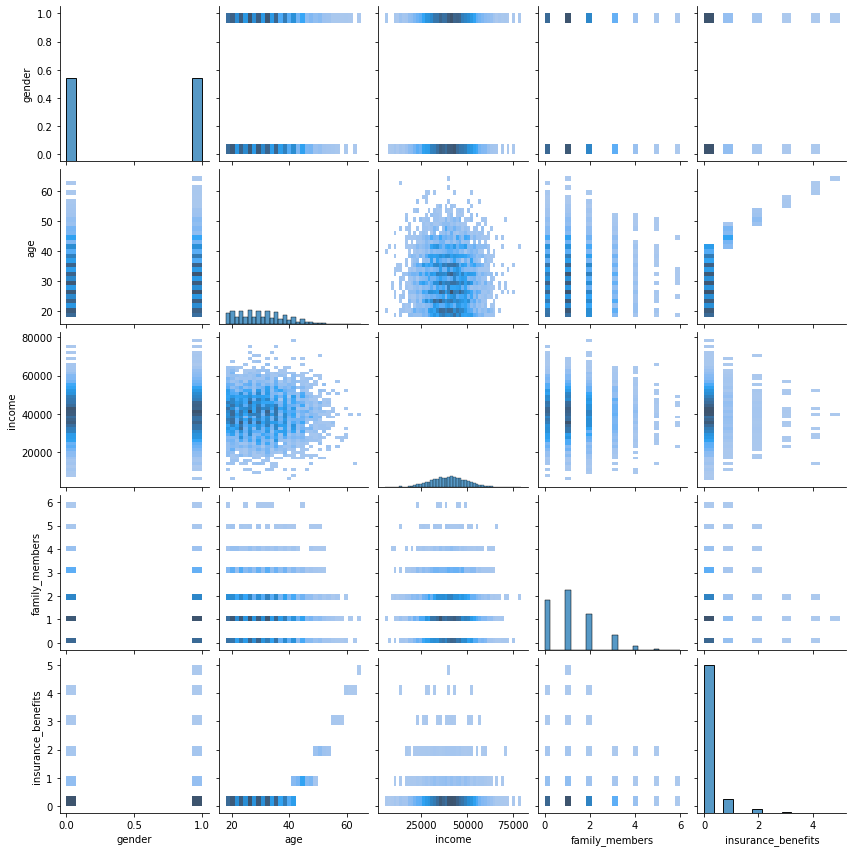

In [15]:
g = sns.pairplot(df, kind='hist')
g.fig.set_size_inches(12, 12)

Ok, it is a bit difficult to spot obvious groups (clusters) as it is difficult to combine several variables simultaneously (to analyze multivariate distributions).  
That's where LA and ML can be quite handy.

# Task 1. Similar Customers

It is necessary to develop a procedure that returns k nearest neighbors (objects) for a given object based on the distance between the objects.
To solve the task, we can try different distance metrics (Euclidean, Manhattan).

We will write a function that returns k nearest neighbors for an $n^{th}$ object based on a specified distance metric.  
The number of received insurance benefits should not be taken into account for this task. 

Test it for four combination of two cases:
- Scaling
  - the data is not scaled
  - the data is scaled with the [MaxAbsScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MaxAbsScaler.html) scaler
- Distance Metrics
  - Euclidean
  - Manhattan

We will answer these questions:
- Does the data being not scaled affect the kNN algorithm? If so, how does that appear?
- How similar are the results using the Manhattan distance metric (regardless of the scaling)?

In [16]:
feature_names = ['gender', 'age', 'income', 'family_members']

In [17]:
class NearestNeighbors:

    @staticmethod
    def euclidean(A, B):
        return A.apply(lambda nbr:(B - nbr).apply(lambda v:np.sqrt(v @ v), axis=1), axis=1)


    @staticmethod
    def manhattan(A, B):
        return A.apply(lambda nbr:np.abs(B - nbr).sum(1), axis=1)
    

    def __init__(self, n_neighbors=5, metric='euclidean'):
        self.n_neighbors = n_neighbors
        self.metric = metric


    def fit(self, X, y=None):
        self.X = X
        return self


    def kneighbors(self, X=None, n_neighbors=None, return_distance=True):
        if n_neighbors is None:
            n_neighbors = self.n_neighbors

        # print(X)
        # print(self.X)

        if self.metric == 'euclidean':
            distances = NearestNeighbors.euclidean(X, self.X)
        elif self.metric == 'manhattan':
            distances = NearestNeighbors.manhattan(X, self.X)
        else:
            raise Exception("metric should be either 'euclidean' or 'manhattan'.")
        #print(distances)

        values = distances.values
        indices = values.argsort()[:, :n_neighbors]
        # print(indices)

        values = np.take_along_axis(values, indices, 1)
        # print(values)

        return (values, indices) if return_distance else indices

# NearestNeighbors(2, metric='euclidean').fit(df.loc[:4, feature_names]).kneighbors(
#     df.loc[4:6, feature_names], return_distance=True)

In [18]:
# # sanity check
#
# sk_KNN(n_neighbors=2, metric='euclidean').fit(df.loc[:4, feature_names]).kneighbors(
#     df.loc[4:6, feature_names], return_distance=True)

In [19]:
def get_knn(df, n, k, metric):
    
    """
    Returns k nearest neighbors

    :param df: pandas DataFrame used to find similar objects within
    :param n: object no for which the nearest neighbours are looked for
    :param k: the number of the nearest neighbours to return
    :param metric: name of distance metric
    """

    # scikit built-in model
    # nbrs = sk_KNN(n_neighbors=k, metric=metric).fit(df[feature_names].values)
    # nbrs_distances, nbrs_indices = nbrs.kneighbors([df.iloc[n][feature_names]], k, return_distance=True)

    # custom model
    nbrs = NearestNeighbors(n_neighbors=k, metric=metric).fit(df[feature_names])
    nbrs_distances, nbrs_indices = nbrs.kneighbors(df.iloc[n][feature_names].to_frame().T, k, return_distance=True)
    # print(nbrs_distances, nbrs_indices)
    
    df_res = pd.concat([
        df.iloc[nbrs_indices[0]], 
        pd.DataFrame(nbrs_distances.T, index=nbrs_indices[0], columns=['distance'])
    ], axis=1)
    
    return df_res

# get_knn(df, 0, 5, 'euclidean')

Scaling the data.

In [20]:
feature_names = ['gender', 'age', 'income', 'family_members']

transformer_mas = sklearn.preprocessing.MaxAbsScaler().fit(df[feature_names].to_numpy())

df_scaled = df.copy()
df_scaled.loc[:, feature_names] = transformer_mas.transform(df[feature_names].to_numpy())

In [21]:
df_scaled.sample(5)

,gender,age,income,family_members,insurance_benefits
3525,1.0,0.769231,0.559494,0.333333,2
928,1.0,0.323077,0.391139,0.333333,0
2929,1.0,0.492308,0.665823,0.500000,0
4004,1.0,0.430769,0.643038,0.000000,0
4785,0.0,0.353846,0.482278,0.333333,0


Now, let's get similar records for a given one, for every combination.

In [22]:
def get_knn_wrapper(n, k):
    display(
        df.iloc[n].to_frame().T,
        get_knn(df, n, k, 'euclidean').rename_axis('euclidean'.ljust(15), axis=1),
        get_knn(df, n, k, 'manhattan').rename_axis('manhattan'.ljust(15), axis=1),
        get_knn(df_scaled, n, k, 'euclidean').rename_axis('euclidean_scaled'.ljust(15), axis=1),
        get_knn(df_scaled, n, k, 'manhattan').rename_axis('manhattan_scaled'.ljust(15), axis=1)
    )

In [23]:
get_knn_wrapper(1, 5)

,gender,age,income,family_members,insurance_benefits
1,0.0,46.0,38000.0,1.0,1.0


euclidean,gender,age,income,family_members,insurance_benefits,distance
1,0,46,38000.0,1,1,0.000000
3920,0,40,38000.0,0,0,6.082763
4948,1,37,38000.0,1,0,9.055385
2528,1,36,38000.0,0,0,10.099505
3593,0,33,38000.0,0,0,13.038405


manhattan,gender,age,income,family_members,insurance_benefits,distance
1,0,46,38000.0,1,1,0.0
3920,0,40,38000.0,0,0,7.0
4948,1,37,38000.0,1,0,10.0
2528,1,36,38000.0,0,0,12.0
3593,0,33,38000.0,0,0,14.0


euclidean_scaled,gender,age,income,family_members,insurance_benefits,distance
1,0.0,0.707692,0.481013,0.166667,1,0.000000
4162,0.0,0.707692,0.477215,0.166667,1,0.003797
1863,0.0,0.707692,0.492405,0.166667,1,0.011392
4986,0.0,0.723077,0.491139,0.166667,1,0.018418
4477,0.0,0.692308,0.459494,0.166667,1,0.026453


manhattan_scaled,gender,age,income,family_members,insurance_benefits,distance
1,0.0,0.707692,0.481013,0.166667,1,0.000000
4162,0.0,0.707692,0.477215,0.166667,1,0.003797
1863,0.0,0.707692,0.492405,0.166667,1,0.011392
4986,0.0,0.723077,0.491139,0.166667,1,0.025511
2434,0.0,0.676923,0.482278,0.166667,1,0.032035


**Does the data being not scaled affect the kNN algorithm? If so, how does that appear?** 

Yes, the data not being scaled does affect the kNN algorithm.  
The algorithm gives more weight to features with higher magnitude (income), while practically ignoring the lesser ones.  
And as a clear giveaway,  
the insurance benefits (target variable) are clearly distinct for the unscaled data between the chosen sample (1) and the selected neighbors (0),  
while they are the same (1) for the scaled data.

**How similar are the results using the Manhattan distance metric (regardless of the scaling)?**

For the unscaled data, euclidean and manhattan output the same results (5/5).  
For the scaled data, euclidean and manhattan output mostly the same results (4/5).  
Both yield similar results.

# Task 2. Is Customer Likely to Receive Insurance Benefit?

We will evaluate whether the kNN classification approach can do better than a dummy model, in accordance with the following:
- Build a KNN-based classifier and measure its quality with the F1 metric for k=1..10 for both the original data and the scaled one.  
That'd be interesting to see how k may influece the evaluation metric, and whether scaling the data makes any difference.
- Build a dummy model which is just random for this case. It should return "1" with some probability. Let's test the model with four probability values: 0, the probability of paying any insurance benefit, 0.5, 1.

The probability of paying any insurance benefit can be defined as

$$
P\{\text{insurance benefit received}\}=\frac{\text{number of clients received any insurance benefit}}{\text{total number of clients}}.
$$

Split the whole data in the 70:30 proportion for the training/testing parts.

In [24]:
df['insurance_benefits'].value_counts()

0    4436
1     423
2     115
3      18
4       7
5       1
Name: insurance_benefits, dtype: int64

In [25]:
# calculate the target

df['insurance_benefits_received'] = (df['insurance_benefits'] > 0).astype('int')
df_scaled['insurance_benefits_received'] = df['insurance_benefits_received']

In [26]:
# check for the class imbalance with value_counts()

pd.concat([
    df['insurance_benefits_received'].value_counts().rename('count'),
    df['insurance_benefits_received'].value_counts(normalize=True).rename('ratio')
], axis=1).rename_axis('insurance_benefits_received', axis=1)

insurance_benefits_received,count,ratio
0,4436,0.8872
1,564,0.1128


There is a heavy class imbalance of 9 to 1.

In [27]:
def get_class_ratio(y):
    """Returns binary class ratio (balance)."""
    
    return int(y.value_counts(normalize=True).to_frame().apply(lambda x:x[0]/x[1]).round())

In [28]:
get_class_ratio(df['insurance_benefits_received'])

8

In [29]:
def upsample(features, target, repeat, random_state=None):
    """Returns balanced (upsampled) samples."""
    
    features_zero = features[target == 0]
    features_one = features[target == 1]
    target_zero = target[target == 0]
    target_one = target[target == 1]
    
    features_upsampled = pd.concat([features_zero] + [features_one] * repeat)
    target_upsampled = pd.concat([target_zero] + [target_one] * repeat)

    return shuffle(features_upsampled, target_upsampled, random_state=random_state)

In [30]:
def eval_classifier(y_true, y_pred, verbose=1):
    
    f1_score = sklearn.metrics.f1_score(y_true, y_pred)
    if verbose:
        print(f'F1: {f1_score:.2f}')
    
    cm = sklearn.metrics.confusion_matrix(y_true, y_pred, normalize='all')
    if verbose:
        print('Confusion Matrix')
        print(cm)
        
    return f1_score

In [31]:
# generating output of a random model

def rnd_model_predict(P, size, seed=42):

    rng = np.random.default_rng(seed=seed)
    return rng.binomial(n=1, p=P, size=size)

In [32]:
for P in [0, df['insurance_benefits_received'].sum() / len(df), 0.5, 1]:

    print(f'The probability: {P:.2f}')
    y_pred_rnd = rnd_model_predict(P, len(df))
        
    eval_classifier(df['insurance_benefits_received'], y_pred_rnd)
    
    print()

The probability: 0.00
F1: 0.00
Confusion Matrix
[[0.8872 0.    ]
 [0.1128 0.    ]]

The probability: 0.11
F1: 0.12
Confusion Matrix
[[0.7914 0.0958]
 [0.0994 0.0134]]

The probability: 0.50
F1: 0.20
Confusion Matrix
[[0.456  0.4312]
 [0.053  0.0598]]

The probability: 1.00
F1: 0.20
Confusion Matrix
[[0.     0.8872]
 [0.     0.1128]]



Our dummy model for the task has top F1 score of 0.20.

In [33]:
class KNeighborsClassifier:
    
    def __init__(self, n_neighbors=5, metric='euclidean'):
        self.n_neighbors = n_neighbors
        self.metric = metric
    
    
    def get_params(self, deep=False):
        return {'n_neighbors': self.n_neighbors, 'metric': self.metric}
        
        
    def fit(self, X, y):
        self.X = X
        self.y = y
        self.knn = NearestNeighbors(self.n_neighbors, self.metric).fit(X)
        return self
    
    
#     def _knn(self, v):
#         distances = []
#         for i in range(self.X.shape[0]):
#             vector = self.X.iloc[i].to_frame().T
#             distances.append(NearestNeighbors.euclidean(v, vector))
#         best_index = np.array(distances).argmin()
#         print(best_index)
#         return self.y.iloc[best_index]
    
    
    def _knn(self, v):
        if self.metric == 'euclidean':
            best_index = NearestNeighbors.euclidean(self.X, v).idxmin().values[0]
        elif self.metric == 'manhattan':
            best_index = NearestNeighbors.manhattan(self.X, v).idxmin().values[0]
            
        # print(best_index)
        return self.y.loc[best_index]
    
    
    def predict(self, X):
        return X.apply(lambda v:self._knn(v.to_frame().T), axis=1).values
    
    
    def score(self, X, y):
        return get_scorer('f1')._score_func(y, self.predict(X))

In [34]:
def run_classification(df, k=5, metric='euclidean', verbose=1):
    
    X = df[feature_names]
    y = df['insurance_benefits_received']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3,
                                                        stratify=y,
                                                        random_state=random_state)
    # print(X_train.shape, y_train.shape)
    # print(X_test.shape, y_test.shape)
    
    X_train, y_train = upsample(X_train, y_train, get_class_ratio(y_train), random_state)
    
    # slow and inefficient
    # model = KNeighborsClassifier(k, metric)
    
    model = sk_KNNC(n_neighbors=k, metric=metric)
    
    model.fit(X_train, y_train)
    
    # cv = cross_validate(model, X_train, y_train, scoring='f1')
    # pprint(cv)
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        y_pred = model.predict(X_test)
        # print(y_pred)
    
    return eval_classifier(y_test, y_pred, verbose)

In [35]:
results = pd.DataFrame(index=np.arange(10)+1)

In [36]:
results['euclidean'] = [run_classification(df, k, 'euclidean', verbose=0) for k in results.index]

In [37]:
results['manhattan'] = [run_classification(df, k, 'manhattan', verbose=0) for k in results.index]

In [38]:
results['euclidean_scaled'] = [run_classification(df_scaled, k, 'euclidean', verbose=0) for k in results.index]

In [39]:
results['manhattan_scaled'] = [run_classification(df_scaled, k, 'manhattan', verbose=0) for k in results.index]

In [40]:
results.T

,1,2,3,4,5,6,7,8,9,10
euclidean,0.594982,0.589928,0.559748,0.561514,0.562162,0.562162,0.495455,0.496583,0.455446,0.456349
manhattan,0.602837,0.597865,0.557994,0.559748,0.549865,0.551351,0.484305,0.488688,0.452381,0.455090
euclidean_scaled,0.922619,0.922619,0.937500,0.937500,0.918033,0.918033,0.900804,0.900804,0.888889,0.888889
manhattan_scaled,0.928144,0.928144,0.945869,0.945869,0.923077,0.923077,0.910569,0.910569,0.884211,0.884211


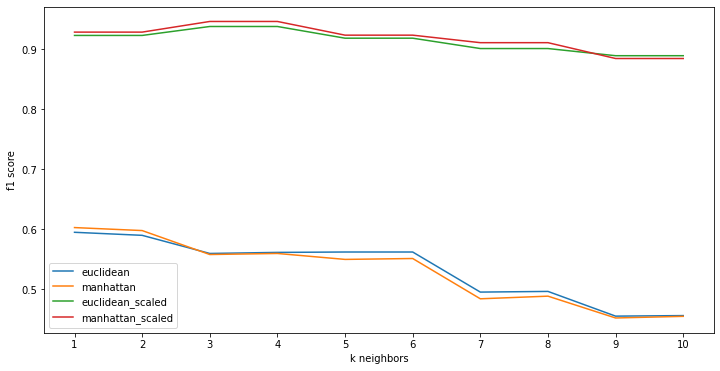

In [41]:
results.plot(figsize=(12, 6))
plt.xticks(results.index)
plt.xlabel('k neighbors')
plt.ylabel('f1 score')
plt.show();

In [42]:
pd.concat([
    results.idxmax().rename('k'),
    results.max().rename('f1')
], axis=1)

,k,f1
euclidean,1,0.594982
manhattan,1,0.602837
euclidean_scaled,3,0.937500
manhattan_scaled,3,0.945869


Our model is doing considerably better than baseline.  
Manhattan distance combined with scaled data shows the best performance (although it's very close to euclidean distance).

# Task 3. Regression (with Linear Regression)

With `insurance_benefits` as the target, will evaluate what RMSE would be for a Linear Regression model.

Let's denote
- $X$ — feature matrix, each row is a case, each column is a feature, the first column consists of unities
- $y$ — target (a vector)
- $\hat{y}$ — estimated tagret (a vector)
- $w$ — weight vector

The task of linear regression in the language of matrices can be formulated as

$$
y = Xw
$$

The training objective then is to find such $w$ that it would minimize the L2-distance (MSE) between $Xw$ and $y$:

$$
\min_w d_2(Xw, y) \quad \text{or} \quad \min_w \text{MSE}(Xw, y)
$$

It appears that there is analytical solution for the above:

$$
w = (X^T X)^{-1} X^T y
$$

The formula above can be used to find the weights $w$ and the latter can be used to calculate predicted values

$$
\hat{y} = X_{val}w
$$

Split the whole data in the 70:30 proportion for the training/validation parts. Use the RMSE metric for the model evaluation.

In [43]:
class MyLinearRegression:
    
    def __init__(self):
        self.weights = None
    
    def fit(self, X, y):
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        self.weights = np.linalg.inv(X2.T @ X2) @ X2.T @ y

    def predict(self, X):
        return X @ self.weights[1:] + self.weights[0]

In [44]:
def eval_regressor(y_true, y_pred):
    
    rmse = np.sqrt(sklearn.metrics.mean_squared_error(y_true, y_pred))
    print(f'RMSE: {rmse:.2f}')
    
    r2_score = np.sqrt(sklearn.metrics.r2_score(y_true, y_pred))
    print(f'R2: {r2_score:.2f}')    

In [45]:
def run_regression(df):
    X = df[['age', 'gender', 'income', 'family_members']].to_numpy()
    y = df['insurance_benefits'].to_numpy()

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

    lr = MyLinearRegression()

    lr.fit(X_train, y_train)
    print('weights:', lr.weights, '', sep='\n')

    y_test_pred = lr.predict(X_test)
    eval_regressor(y_test, y_test_pred)

In [46]:
display(Markdown('### unscaled data'))
run_regression(df)

### unscaled data

weights:
[-9.43539012e-01  3.57495491e-02  1.64272726e-02 -2.60743659e-07
 -1.16902127e-02]

RMSE: 0.34
R2: 0.66


In [47]:
display(Markdown('### scaled data'))
run_regression(df_scaled)

### scaled data

weights:
[-0.94353901  2.32372069  0.01642727 -0.02059875 -0.07014128]

RMSE: 0.34
R2: 0.66


Regression metrics are the same for both scaled and unscaled data.

Although scaling doesn't influence the quality of linear regression model,  
the weights of the model trained on scaled data take the difference of magnitudes of features into account - as are more easily interpretable.

# Task 4. Obfuscating Data

It best to obfuscate data by multiplying the numerical features (the matrix $X$) by an invertible matrix $P$. 

$$
X' = X \times P
$$

We'll do that and check how the features' values will look like after the transformation.  
\* The invertible property is important here so need to make sure that $P$ is indeed invertible.

In [48]:
personal_info_column_list = ['gender', 'age', 'income', 'family_members']
df_pn = df[personal_info_column_list]

In [49]:
X = df_pn.to_numpy()

In [50]:
X

array([[1.00e+00, 4.10e+01, 4.96e+04, 1.00e+00],
       [0.00e+00, 4.60e+01, 3.80e+04, 1.00e+00],
       [0.00e+00, 2.90e+01, 2.10e+04, 0.00e+00],
       ...,
       [0.00e+00, 2.00e+01, 3.39e+04, 2.00e+00],
       [1.00e+00, 2.20e+01, 3.27e+04, 3.00e+00],
       [1.00e+00, 2.80e+01, 4.06e+04, 1.00e+00]])

Generating a random matrix $P$.

In [51]:
rng = np.random.default_rng(seed=42)
P = rng.random(size=(X.shape[1], X.shape[1]))

Checking the matrix $P$ is invertible

In [52]:
def is_invertible(A):
    return ((A @ np.linalg.inv(A)).round(15) == np.eye(A.shape[0])).all()

In [53]:
np.linalg.inv(P)

array([[ 0.41467992, -1.43783972,  0.62798546,  1.14001268],
       [-1.06101789,  0.44219337,  0.1329549 ,  1.18425933],
       [ 1.42362442,  1.60461607, -2.0553823 , -1.53699695],
       [-0.11128575, -0.65813802,  1.74995517, -0.11816316]])

In [54]:
is_invertible(P)

True

In [55]:
X_P = X @ P
X_P

array([[ 6359.71527314, 22380.40467609, 18424.09074184, 46000.69669016],
       [ 4873.29406479, 17160.36702982, 14125.78076133, 35253.45577301],
       [ 2693.11742928,  9486.397744  ,  7808.83156024, 19484.86063067],
       ...,
       [ 4346.2234249 , 15289.24126492, 12586.16264392, 31433.50888552],
       [ 4194.09324155, 14751.9910242 , 12144.02930637, 30323.88763426],
       [ 5205.46827354, 18314.24814446, 15077.01370762, 37649.59295455]])

Values have been successfully obfuscated, they look nothing like the original.

Can we recover the original data from $X'$ if we know $P$?  
We'll check that with calculations by moving $P$ from the right side of the formula above to the left one.

In [56]:
r_X_P = X_P @ np.linalg.inv(P)
r_X_P

array([[ 1.00000000e+00,  4.10000000e+01,  4.96000000e+04,
         1.00000000e+00],
       [-3.63797881e-12,  4.60000000e+01,  3.80000000e+04,
         1.00000000e+00],
       [ 1.81898940e-12,  2.90000000e+01,  2.10000000e+04,
         0.00000000e+00],
       ...,
       [ 0.00000000e+00,  2.00000000e+01,  3.39000000e+04,
         2.00000000e+00],
       [ 1.00000000e+00,  2.20000000e+01,  3.27000000e+04,
         3.00000000e+00],
       [ 1.00000000e+00,  2.80000000e+01,  4.06000000e+04,
         1.00000000e+00]])

Values are mostly recovered (with minor differences in precision).

Print all three cases for a few customers:
- The original data
- The transformed one
- The reversed (recovered) one

In [57]:
for i in range(3):
    display(
        pd.DataFrame([X[i], X_P[i], r_X_P[i]], 
                     index=['original', 'transformed', 'recovered'], 
                     columns=df_pn.columns
                    ).rename_axis(f'customer {i}', axis=1)
    )

customer 0,gender,age,income,family_members
original,1.000000,41.000000,49600.000000,1.00000
transformed,6359.715273,22380.404676,18424.090742,46000.69669
recovered,1.000000,41.000000,49600.000000,1.00000


customer 1,gender,age,income,family_members
original,0.000000e+00,46.00000,38000.000000,1.000000
transformed,4.873294e+03,17160.36703,14125.780761,35253.455773
recovered,-3.637979e-12,46.00000,38000.000000,1.000000


customer 2,gender,age,income,family_members
original,0.000000e+00,29.000000,21000.00000,0.000000
transformed,2.693117e+03,9486.397744,7808.83156,19484.860631
recovered,1.818989e-12,29.000000,21000.00000,0.000000


Some values are not exactly the same as they are in the original data.

The precision is capped at some point (only very small values are not recovered properly).



In [58]:
(P @ np.linalg.inv(P)).round(15)

array([[ 1., -0., -0.,  0.],
       [ 0.,  1.,  0.,  0.],
       [ 0., -0.,  1.,  0.],
       [ 0., -0., -0.,  1.]])

In [59]:
(P @ np.linalg.inv(P)).round(16)

array([[ 1.e+00, -1.e-16, -2.e-16,  0.e+00],
       [ 0.e+00,  1.e+00,  0.e+00,  0.e+00],
       [ 0.e+00, -1.e-16,  1.e+00,  1.e-16],
       [ 1.e-16, -3.e-16, -2.e-16,  1.e+00]])

## Proof That Data Obfuscation Can Work with LR

We should prove _analytically_ that the given obfuscation method won't affect linear regression in terms of predicted values i.e. their values will remain the same.

So, the data is obfuscated and there is $X \times P$ instead of just $X$ now. Consequently, there are other weights $w_P$ as
$$
w = (X^T X)^{-1} X^T y \quad \Rightarrow \quad w_P = [(XP)^T XP]^{-1} (XP)^T y
$$

How would $w$ and $w_P$ be linked if we simplify the formula for $w_P$ above? 

What would be predicted values with $w_P$? 

What does that mean for the quality of linear regression if you measure it with RMSE?

**Answer**

W and Wp and related through the inverse of P.  
The predictions are equal, meaning that RMSE will be the same.

**Analytical proof**

$ w = (X^T X)^{-1} X^T y $  
$ y_{pred} = X w $

$$ w_P = [(XP)^T XP]^{-1} (XP)^T y $$
$$ \Rightarrow [P^T X^T XP]^{-1} P^T X^T y $$
$$ \Rightarrow P^{-1} (X^T X)^{-1} (P^T)^{-1} P^T X^T y $$
$$ \Rightarrow P^{-1} (X^T X)^{-1} I_n X^T y $$
$$ \Rightarrow P^{-1} (X^T X)^{-1} X^T y $$
$$ \Rightarrow P^{-1} w $$

$$ w_P = P^{-1} w $$

$$ {y_{pred}}_{w_{p}} = XP w_{p} = XP P^{-1} w = X I_{n} w = X w = y_{pred} $$

## Test Linear Regression With Data Obfuscation

Now, let's prove Linear Regression can work computationally with the chosen obfuscation transformation.

We will build a procedure that runs Linear Regression optionally with the obfuscation,  
then run Linear Regression for the original data and the obfuscated one,  
and compare the predicted values and the RMSE, $R^2$ metric values.

**Procedure**

- Create a square matrix $P$ of random numbers.
- Check that it is invertible. If not, repeat the first point until we get an invertible matrix.
- apply obfuscation on X: X@P
- Use $XP$ as the new feature matrix

In [60]:
def run_obf_regression(df, obf=True):
    X = df[['age', 'gender', 'income', 'family_members']].to_numpy()
    y = df['insurance_benefits'].to_numpy()
    
    if obf:
        P = None
        i = 0
        while P is None or not is_invertible(P):
            if i == 3:
                raise Exception('failed to create invertible matrix')
            rng = np.random.default_rng(seed=42+i)
            P = rng.random(size=(X.shape[1], X.shape[1]))
            
        # print(P)
        X = X @ P

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)
    print('data sample:', X_train[0])
    print()

    lr = MyLinearRegression()

    lr.fit(X_train, y_train)
    print('weights:', lr.weights.tolist(), '', sep='\n')

    y_test_pred = lr.predict(X_test)
    eval_regressor(y_test, y_test_pred)

In [61]:
run_obf_regression(df)

data sample: [ 2610.34010545  9110.52342024  7515.01942918 18740.87644758]

weights:
[-0.9435390287741936, -0.022122380231071867, -0.04451116750401949, 0.09522182734539458, -0.013408948243483126]

RMSE: 0.34
R2: 0.66


In [62]:
run_obf_regression(df, obf=False)

data sample: [   29.     0. 20200.     0.]

weights:
[-0.94353901163207, 0.03574954907317057, 0.016427272643113142, -2.607436590627938e-07, -0.011690212742885939]

RMSE: 0.34
R2: 0.66


Since the magnitude of the values has changed considerably, the weights are different.  
But the underlying relationships between the data points are perserved, hence the resulting metric scores are the same.

# Conclusions

We’ve used Nearest Neighbours algorithm to select similar entries of a target (least distant vector).  

Our classification task had a class imbalance, but with upsampling and normalisation of the data our classification KNN model (k=3) did a great job and obtained an F1 score of 0.946 which is a huge improvement over the dummy model (which had a F1 score of 0.20).

For the regression task we’ve built a Linear Regression model which scored RMSE of 0.34 (regardless of scaling),

And then proved that we can implement a model which also obfuscates the data (for added privacy of users) and still gets the same score.

All in all, a very productive day :)

<br>

# Appendices 

## Appendix A: Properties of Matrices

Matrices have many properties in Linear Algebra. A few of them, relevant to the analytical proof, are listed here.

<table>
<tr>
<td>Distributivity</td><td>$A(B+C)=AB+AC$</td>
</tr>
<tr>
<td>Non-commutativity</td><td>$AB \neq BA$</td>
</tr>
<tr>
<td>Associative property of multiplication</td><td>$(AB)C = A(BC)$</td>
</tr>
<tr>
<td>Multiplicative identity property</td><td>$IA = AI = A$</td>
</tr>
<tr>
<td></td><td>$A^{-1}A = AA^{-1} = I$
</td>
</tr>    
<tr>
<td></td><td>$(AB)^{-1} = B^{-1}A^{-1}$</td>
</tr>    
<tr>
<td>Reversivity of the transpose of a product of matrices,</td><td>$(AB)^T = B^TA^T$</td>
</tr>    
</table>